In [1]:
import pandas as pd
import numpy as np
import itertools
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import PassiveAggressiveClassifier, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
import matplotlib.pyplot as plt

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Comparing Fake News Classifiers

I wrote a longer explanation of the methodology and approach for detecting fake news using scikit-learn on DataCamp (and you can [find the notebook on my GitHub](https://github.com/kjam/random_hackery/blob/master/Attempting%20to%20detect%20fake%20news.ipynb)). I would start there if you are curious as to why I chose the data, what I learned about the models and so forth.

In this notebook, I wanted to compare some of the features learned by each classifier to see if there was overlap or patterns in the features.

In [3]:
df = pd.read_csv('data/fake_or_real_news.csv')

In [4]:
y = df.label

In [5]:
df = df.drop('label', axis=1)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(df['text'], y, test_size=0.33, random_state=53)

In [7]:
count_vectorizer = CountVectorizer(stop_words='english')
count_train = count_vectorizer.fit_transform(X_train)
count_test = count_vectorizer.transform(X_test)

In [8]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7)
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
tfidf_test = tfidf_vectorizer.transform(X_test)

### Training models

Now I have my vectors and I can create my different classifiers. In my post I noted that there is definitely noise in the dataset, so we should expect to see that reflected in our features. Normally, I would spend some time cleaning the data, but this was a small proof of concept and investigation. I hoped merely that at least one model would be able to correct for the noise.

I will compare the following models (and training data):

- multinomialNB with counts (`sgd_count_clf`)
- multinomialNB with tf-idf (`mn_tfidf_clf`)
- passive aggressive with tf-idf (`pa_tfidf_clf`)
- linear svc with tf-idf (`svc_tfidf_clf`)
- linear sgd with tf-idf (`sgd_tfidf_clf`)

For speed and clarity, I am primarily not doing parameter tuning, although this could be added as a step (perhaps in a scikit-learn Pipeline).

In [9]:
mn_count_clf = MultinomialNB(alpha=0.1) 

In [10]:
mn_count_clf.fit(count_train, y_train)
pred = mn_count_clf.predict(count_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)

accuracy:   0.893


In [11]:
mn_tfidf_clf = MultinomialNB(alpha=0.1) 

In [12]:
mn_tfidf_clf.fit(tfidf_train, y_train)
pred = mn_tfidf_clf.predict(tfidf_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)

accuracy:   0.898


In [13]:
pa_tfidf_clf = PassiveAggressiveClassifier(n_iter=50)

In [14]:
pa_tfidf_clf.fit(tfidf_train, y_train)
pred = pa_tfidf_clf.predict(tfidf_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)

c:\users\dell exclusive\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


accuracy:   0.936


In [15]:
svc_tfidf_clf = LinearSVC()

In [16]:
svc_tfidf_clf.fit(tfidf_train, y_train)
pred = svc_tfidf_clf.predict(tfidf_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)

accuracy:   0.936


In [17]:
sgd_tfidf_clf = SGDClassifier()

In [18]:
sgd_tfidf_clf.fit(tfidf_train, y_train)
pred = sgd_tfidf_clf.predict(tfidf_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)

accuracy:   0.934


c:\users\dell exclusive\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


In [19]:
sgd_tfidf_clf.decision_function?

In [20]:
mn_count_clf.predict_proba?

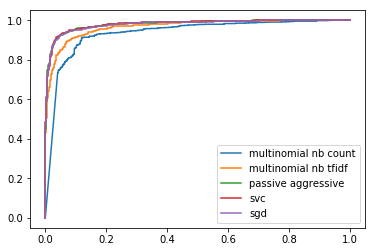

In [21]:
plt.figure(0).clf()

for model, name in [ (mn_count_clf, 'multinomial nb count'),
                     (mn_tfidf_clf, 'multinomial nb tfidf'),
                     (pa_tfidf_clf, 'passive aggressive'),
                     (svc_tfidf_clf, 'svc'),
                     (sgd_tfidf_clf, 'sgd')]:
    if 'count' in name:
        pred = model.predict_proba(count_test)[:,1]
    elif 'multinomial' in name:
        pred = model.predict_proba(tfidf_test)[:,1]
    else: 
        pred = model.decision_function(tfidf_test)
    fpr, tpr, thresh = metrics.roc_curve(y_test.values, pred, pos_label='REAL')
    plt.plot(fpr,tpr,label="{}".format(name))

plt.legend(loc=0)

### Introspecting models

My main goal for this notebook is not to compare accuracy, but to compare features learned. To do so, we can use the method shown in this [very useful StackOverflow answer](https://stackoverflow.com/a/26980472) to show significant features in a binary classifier. I will use a modified version to return top features for each label.

In [22]:
def most_informative_feature_for_binary_classification(vectorizer, classifier, n=100):
    """
    See: https://stackoverflow.com/a/26980472
    
    Identify most important features if given a vectorizer and binary classifier. Set n to the number
    of weighted features you would like to show. (Note: current implementation merely prints and does not 
    return top classes.)
    
    Modified by @kjam to support a dict return.
    """

    class_labels = classifier.classes_
    feature_names = vectorizer.get_feature_names()
    topn_class1 = sorted(zip(classifier.coef_[0], feature_names))[:n]
    topn_class2 = sorted(zip(classifier.coef_[0], feature_names))[-n:]

    return {class_labels[0]: topn_class1,
            class_labels[1]: topn_class2
    }


most_informative_feature_for_binary_classification(tfidf_vectorizer, pa_tfidf_clf, n=10)

{'FAKE': [(-4.776513482727386, '2016'),
  (-4.163435787160144, 'hillary'),
  (-4.052063735803983, 'october'),
  (-3.070407989667898, 'share'),
  (-2.9237854000567762, 'article'),
  (-2.7663401361788607, 'november'),
  (-2.499215388966746, 'print'),
  (-2.413324070889435, 'email'),
  (-2.3697931446191354, 'oct'),
  (-2.3005865268458594, 'advertisement')],
 'REAL': [(2.2051658958712363, 'sunday'),
  (2.2505798233222114, 'islamic'),
  (2.3143487530559432, 'gop'),
  (2.3164533228874364, 'friday'),
  (2.328225002706565, 'candidates'),
  (2.50271334707507, 'marriage'),
  (2.569396207025936, 'tuesday'),
  (2.597612634042832, 'cruz'),
  (2.721818898292385, 'says'),
  (4.81820682033209, 'said')]}

In [23]:
classifiers = [(mn_count_clf, count_vectorizer),
               (mn_tfidf_clf, tfidf_vectorizer),
               (pa_tfidf_clf, tfidf_vectorizer),
               (svc_tfidf_clf, tfidf_vectorizer),
               (sgd_tfidf_clf, tfidf_vectorizer)]

In [24]:
results = {}
for clf, vct in classifiers:
    results[clf] = most_informative_feature_for_binary_classification(vct, clf, n=10)

In [25]:
results

{MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True): {'FAKE': [(-16.067750538483136,
    '0000'),
   (-16.067750538483136, '000035'),
   (-16.067750538483136, '0001'),
   (-16.067750538483136, '0001pt'),
   (-16.067750538483136, '000km'),
   (-16.067750538483136, '0011'),
   (-16.067750538483136, '006s'),
   (-16.067750538483136, '007'),
   (-16.067750538483136, '007s'),
   (-16.067750538483136, '008s')],
  'REAL': [(-5.675959082863306, 'republican'),
   (-5.582298794347825, 'campaign'),
   (-5.520542422049422, 'new'),
   (-5.463370874939617, 'state'),
   (-5.459162531269605, 'obama'),
   (-5.429949870021241, 'president'),
   (-5.403667459399097, 'people'),
   (-4.929358535752954, 'clinton'),
   (-4.541306857712, 'trump'),
   (-4.424753408851144, 'said')]},
 MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True): {'FAKE': [(-12.641778440826338,
    '0000'),
   (-12.641778440826338, '000035'),
   (-12.641778440826338, '0001'),
   (-12.641778440826338, '0001pt'),
   (-12.6417

But this is both a bit hard to read and compare. What I really want is to see these possibly with ranks and compare the tokens to one another. Let's transform the data to look better for what we are trying to measure.

In [26]:
comparable_results = {'REAL': {}, 'FAKE': {}}
for clf, data in results.items():
    clf_name = clf.__class__.__name__
    for label, features in data.items():
        for rank, score_tuple in enumerate(features):
            if score_tuple[1] in comparable_results[label]:
                comparable_results[label][score_tuple[1]].append((rank + 1, clf_name))
            else:
                comparable_results[label][score_tuple[1]] = [(rank + 1, clf_name)]

Now these are a bit easier to compare and read:

In [27]:
comparable_results['FAKE']

{'0000': [(1, 'MultinomialNB'), (1, 'MultinomialNB')],
 '000035': [(2, 'MultinomialNB'), (2, 'MultinomialNB')],
 '0001': [(3, 'MultinomialNB'), (3, 'MultinomialNB')],
 '0001pt': [(4, 'MultinomialNB'), (4, 'MultinomialNB')],
 '000km': [(5, 'MultinomialNB'), (5, 'MultinomialNB')],
 '0011': [(6, 'MultinomialNB'), (6, 'MultinomialNB')],
 '006s': [(7, 'MultinomialNB'), (7, 'MultinomialNB')],
 '007': [(8, 'MultinomialNB'), (8, 'MultinomialNB')],
 '007s': [(9, 'MultinomialNB'), (9, 'MultinomialNB')],
 '008s': [(10, 'MultinomialNB'), (10, 'MultinomialNB')],
 '2016': [(1, 'PassiveAggressiveClassifier'),
  (1, 'LinearSVC'),
  (1, 'SGDClassifier')],
 'hillary': [(2, 'PassiveAggressiveClassifier'),
  (2, 'LinearSVC'),
  (2, 'SGDClassifier')],
 'october': [(3, 'PassiveAggressiveClassifier'),
  (3, 'LinearSVC'),
  (3, 'SGDClassifier')],
 'share': [(4, 'PassiveAggressiveClassifier'),
  (6, 'LinearSVC'),
  (8, 'SGDClassifier')],
 'article': [(5, 'PassiveAggressiveClassifier'),
  (4, 'LinearSVC'),
  (4

I immediately noticed the multinomial models had picked up quite a bit of noise from the dataset. These models likely would have benefit from some preprocessing. I also noticed that *most* of the models had picked up what I would consider noise, such as `2016` and the words `print` and `share` (which are clearly scraping artifacts).

Let's see if we can score the tokens by popularity and rank. I also wanted to add in a warning message in case I had overlap between my real and fake tokens. (This may be the case if you take a larger n-features from each)

In [28]:
agg_results = {}
for label, features in comparable_results.items():
    for feature, ranks in features.items():
        if feature in agg_results:
            print("WARNING! DUPLICATE LABEL!!! {}".format(feature))
        agg_results[feature] = {
            'label': label,
            'agg_rank': np.mean([r[0] for r in ranks]),
            'count': len(ranks)
        }

I can then put this into a dataframe, for easier transformations and viewing.

In [29]:
comparison_df = pd.DataFrame(agg_results).T

In [30]:
comparison_df.head()

,agg_rank,count,label
republican,2,2,REAL
campaign,3,2,REAL
new,3,1,REAL
state,3,2,REAL
obama,6,2,REAL


To investigate the top real and fake labels, I would advise to sort by count. Let's see my top 10 tokens for real and fake news ranked by the number of classifiers that used them as a top feature.

In [31]:
comparison_df[comparison_df['label'] == 'REAL'].sort_values('count', ascending=0).head(10)

,agg_rank,count,label
said,9.8,5,REAL
cruz,3.5,4,REAL
tuesday,8,3,REAL
friday,3,3,REAL
islamic,5,3,REAL
says,8.66667,3,REAL
conservative,5.5,2,REAL
clinton,8,2,REAL
trump,9.5,2,REAL
president,5.5,2,REAL


In [32]:
comparison_df[comparison_df['label'] == 'FAKE'].sort_values('count', ascending=0).head(10)

,agg_rank,count,label
hillary,2,3,FAKE
print,7,3,FAKE
november,5.33333,3,FAKE
article,4.33333,3,FAKE
share,6,3,FAKE
october,3,3,FAKE
2016,1,3,FAKE
000035,2,2,FAKE
election,7,2,FAKE
advertisement,10,2,FAKE


### Conclusion

As expected, the bag-of-words and TF-IDF vectors didn't do much to determine meaningful features to classify fake or real news. As outlined in my DataCamp post, this problem is a lot harder than simple text classification.

That said, I did learn a few things. Namely, that linear models handle noise in this case better than the Naive Bayes multinomial classifier did. Also, finding a good dataset that has been scraped from the web and tagged for this problem would likely be a great help, and worth more of my time than parameter tuning on a clearly noisy and error prone dataset.

If you spend some time researching and find anything interesting, feel free to share your findings and notes in the comments or you can always reach out on Twitter (I'm [@kjam](https://twitter.com/kjam)).

I hope you had some fun exploring a new NLP dataset with me!

### Appendix A: Top features

Once I realized the Naive Bayes classifiers had identified many noisy tokens in alphabetical order as top fake news classifiers, I decided to see just how many "top features" the model had. 

In [33]:
feature_names = count_vectorizer.get_feature_names()
for idx, ftr_weight in enumerate(sorted(zip(mn_count_clf.coef_[0], feature_names))):
    if ftr_weight[0] <= -16.067750538483136:
        continue
    print(idx, ftr_weight)
    break

20161 (-13.669855265684765, '00000031')
